In [2]:
import numpy as np 
from matplotlib import pyplot as plt
import cv2 

In [3]:
# In this notebook, we implemement the Gaussian Mixture Kalman Filter (GMKF) from Wills et. al. 2017

class GMKF():
    def __init__(self, x_init, std_x, y_init, std_y, dynamics_params, x_mean, y_mean, N_max = 5) -> None:
        # mean trajectories
        self.x_mean = x_mean
        self.y_mean = y_mean
        # time variable
        self.t = 0
        # these are also p(x_1 | y_1) or 1|1, or t|t
        self.N = 1
        self.wx = [1]
        self.mu_x = [x_init]
        self.std_x = [std_x]
        self.P_x = [std_x**2]
        self.wy = [1]
        self.y = [y_init]
        self.std_y = [std_y]
        self.P_y = [self.std_y**2]
        # dynamics params is a tuple of alpha_left, mu_left, std_left, alpha_center, mu_center, std_center, alpha_right, mu_right, std_right, std_y
        self.dynamics_params = dynamics_params 
        self.Nx = 3 # number of mixture components of the dynamics model
        self.N_max = N_max # maximum number of mixture components for the state

    def predict(self): # p(x_{t+1} | y_{1:t})
        # predict the state of the system at the next time step
        # the prediction is a mixture of Gaussians

        # ================== #
        # For lateral/lane change dynamics/x #
        # ================== #
        # first, we compute the number of mixture components in the prediction t+1|1:t
        N_tPlus1_t = self.N * self.Nx # N is the number of components for t|t, Nx is the number of components for t+1|t or the dynamics model
        # then, we compute the means of each mixture component
        
        mu_x_pred = np.zeros(N_tPlus1_t)
        P_x_pred = np.zeros(N_tPlus1_t)
        w_x_pred = np.zeros(N_tPlus1_t)

        for s in range(self.N): # s is the index of t|t mixture
            for j in range(self.Nx): # j is the index of t+1|t mixture, or the dynamics model. j=0: left, j=1: center, j=2: right
                l = self.Nx * s + j # lth mixture component of t+1|1:t
                
                x_tPlus1_t = (self.x_mean[self.t+1] - self.x_mean[self.t]) + self.x[s] + self.dynamics_params[1 + 3*j]
                # in dynamics_params, the variances are at index 2, 5, 8
                P_tPlus1_t = self.P_x[s] + self.dynamics_params[2 + 3*j]**2 # the variance is the sum of the variances of the dynamics and the measurement
                w_tPlus1_t = self.wx[s] * self.dynamics_params[0 + 3*j] # the weight is the product of the weights of the dynamics and the measurement

                mu_x_pred[l] = x_tPlus1_t
                P_x_pred[l] = P_tPlus1_t
                w_x_pred[l] = w_tPlus1_t

        # ================== #
        # For longitudinal dynamics/y #
        # ================== #
        # For longitudinal component, there is just one mixture component, so it's similar to a regular Kalman Filter
        # TODO: Implement this ================== #
        mu_y_pred = []
        P_y_pred = []
        w_y_pred = []

        self.t += 1

        # at the end of the prediction step, we have 3x the number of mixture components for the state
        return mu_x_pred, P_x_pred, w_x_pred, mu_y_pred, P_y_pred, w_y_pred




# Unit Test & Sanity Check for GMKF Predict Function 

First, let's pick a sample trajectory, prior to smoothing.

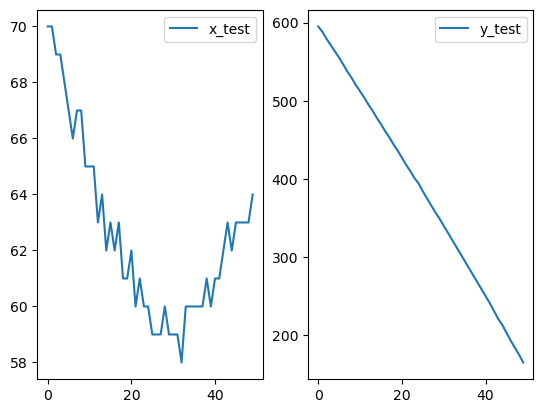

In [4]:
x_mean = np.load('x_mean.npy')
y_mean = np.load('y_mean.npy')
x_samp = np.load('x_sample_from_video.npy')
y_samp = np.load('y_sample_from_video.npy')

x_test = x_samp[0,:]
y_test = y_samp[0,:]

plt.subplot(1,2,1)
plt.plot(x_test)
# plt.plot(x_mean)
plt.legend(['x_test', 'x_mean'])
plt.subplot(1,2,2)
plt.plot(y_test)
# plt.plot(y_mean)
plt.legend(['y_test', 'y_mean'])

We will smooth this particular trajectory using GMKF.

In [ ]:
# alpha_left, mu_left, std_left, alpha_center, mu_center, std_center, alpha_right, mu_right, std_right, std_y
filt = GMKF(x_init=x_test[0], std_x=0.1, y_init=y_test[0], std_y=0.1, 
            dynamics_params=(0.05, -1.5, 0.1, 0.9, 0, 0.5, 0.05, 1.5, 0.1, 1.2), 
            x_mean=x_mean, y_mean=y_mean)